<h1>Algorithmic Trading using MACD</h1>
<h2 style="color:red;">**This project is not investment advice.**</h2>
<p></p>
<p>
    <b>MACD</b> Crossover Strategy is <b>
    algorithmic trading using technical indicator
    that uses exponential moving average to determine
    the momentum direction of market.
    </b>.
    <b>MACD</b> is an initial for
    <b>M</b>oving <b>A</b>verage <b>C</b>onvergence/<b>D</b>ivervence(MACD).
    It is used to determine when to buy and sell stocks.
</p>
<ul>
    <li>When MACD line <b>crosses over the signal line</b>, it is <b>a good time to buy</b>.</li>
    <li>When MACD line is <b>below the signal line</b>, it is <b>a good time to sell</b> .</li>
</ul>
<p><b>MACD</b> line is computed by subtracting long-term exponential moving average
    from short-term exponential moving average. Short-term usually lasts 12 periods and long-term lasts 9 periods.</p>
    
<p>Let's import essential packages.</p>
<h3>Please Make an account at IEX Cloud and grab your token!</h3>

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
import requests           #handles REST API(HTTP/HTTPS) calls
IEX_CLOUD_API_TOKEN = "your token here" #write your token here

plt.style.use('fivethirtyeight')

<h1>Table of Contents</h1>
<p></p>
<div>
    <ol>
        <li><a href="#1">Choose the target stock with symbol</a></li>
        <li><a href="#2">Import the stock symbol with the API call</a></li>
        <li><a href="#3">Visualize the price change</a></li>
        <li><a href="#4">Calculate the MACD and Signal lines</a></li>
        <li><a href="#5">Visualize the MACD and signal lines</a></li>
        <li><a href="#6">Compute when to buy or sell</a></li>
        <li><a href="#7">Visualize the buy/sell signal with stock price</a></li>
    </ol>
</div>

<h2 id="1">1. Choose the target stock with symbol among S&P500</h2>

In [2]:
symbols = pd.read_csv('sp_500_stocks.csv')['Ticker'].values

#verifying the data
symbols

def get_target_stock_symbol():
    """
        This function returns the target stock symbol among S&P500.
    """
    symbol = ""
    while True:
        try:
            symbol = input("Type your target stock: ")
            if symbol in symbols:
                break
            else:
                print("Not available.")
        except:
            print("Not available.")
    return symbol

symbol = get_target_stock_symbol()

Type your target stock: AAPL


<h2 id="2">2. Import Stock symbols and making a test API call</h2>
<p></p>
<div>
    <p>
        Let's import our data from IEX Cloud.
        IEX Cloud provides useful financial data. 
        This project makes use of sample data randomly generated.
    </p>
</div>

In [3]:
sandbox_url = "https://sandbox.iexapis.com/stable"
Type = "chart"
history = "1y"

api_url = lambda base_url, symbol, Type, token : "{base_url}/stock/{symbol}/{Type}/{history}?token={token}".format(
    base_url = base_url,
    symbol = symbol,
    Type = Type,
    history = history,
    token = token
)
req = requests.get(api_url(
    sandbox_url,
    symbol,
    Type,
    IEX_CLOUD_API_TOKEN
))
assert(req.status_code == 200)


If the code cell above is executed without an error, let's parse the data into the DataFrame.

In [4]:
res = req.json()

columns = ['date', 'open', 'high', 'low', 'close', 'volume']
data = {col: [] for col in columns}
for datum in res:
    for col in columns:
        data[col].append(datum[col])
df = pd.DataFrame(data).set_index('date')
df

,open,high,low,close,volume
date,,,,,
2020-07-16,100.4154,100.4786,96.7370,100.4786,111295143
2020-07-17,101.3641,101.3641,96.5400,99.9284,96777027
2020-07-20,100.4224,102.7000,97.4505,101.7070,92272530
2020-07-21,99.6315,100.5800,98.0000,98.0000,108554777
2020-07-22,101.4372,101.4372,97.1055,98.4633,89550257
...,...,...,...,...,...
2021-07-09,144.2500,150.3300,144.2500,150.0500,103306680
2021-07-12,146.8500,153.4900,146.8500,151.5000,76550010
2021-07-13,149.2200,152.3900,143.7100,146.0100,101690014


<h2 id="3">3. Visualize the Price Change</h2>
<div>
    <p>
        Before we dive into building a model,let's visualize the data
        and understand the data first.
    </p>
</div>

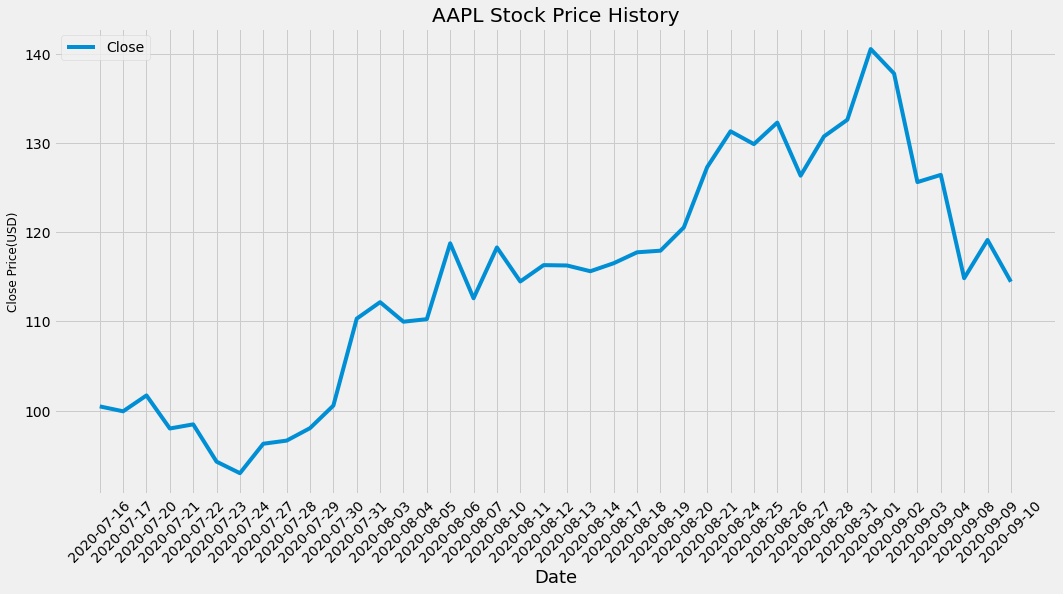

In [17]:
plt.figure(figsize = (16, 8))
plt.title(f"{symbol} Stock Price History")
plt.plot(df['close'][:40], label = "Close")
plt.xlabel('Date', fontsize = 18)
plt.xticks(rotation = 45)
plt.ylabel('Close Price(USD)', fontsize = 12)
plt.legend(loc = "upper left")
plt.show()

<h2 id="4">4. Calculate MACD and Signal Lines</h2>
<p></p>
<div>
    <p>
        To signal when to buy or sell, we need to calculate MACD and Signal line values first.
    </p>
</div>
<div>
    <ol>
        <li>Calculate the short-term exponential moving average(EMA)</li>
        <li>Calculate the long-term exponential moving average(EMA)</li>
        <li>Calculate MACD</li>
        <li>Calculate the signal line</li>
    </ol>
</div>

In [6]:
EMA = lambda period: df['close'].ewm(span = period, adjust = False).mean()

#1~2. short and long term EMA
shortEMA, longEMA = EMA(12), EMA(26)
#3.MACD Line 
MACD = shortEMA - longEMA
#4. Signal Line
signal = MACD.ewm(span = 9, adjust = False).mean()
#Writing to the DataFrame
df['MACD'] = MACD
df['signal'] = signal

<h2 id="5">5. Plot the chart using MACD and signal line</h2>

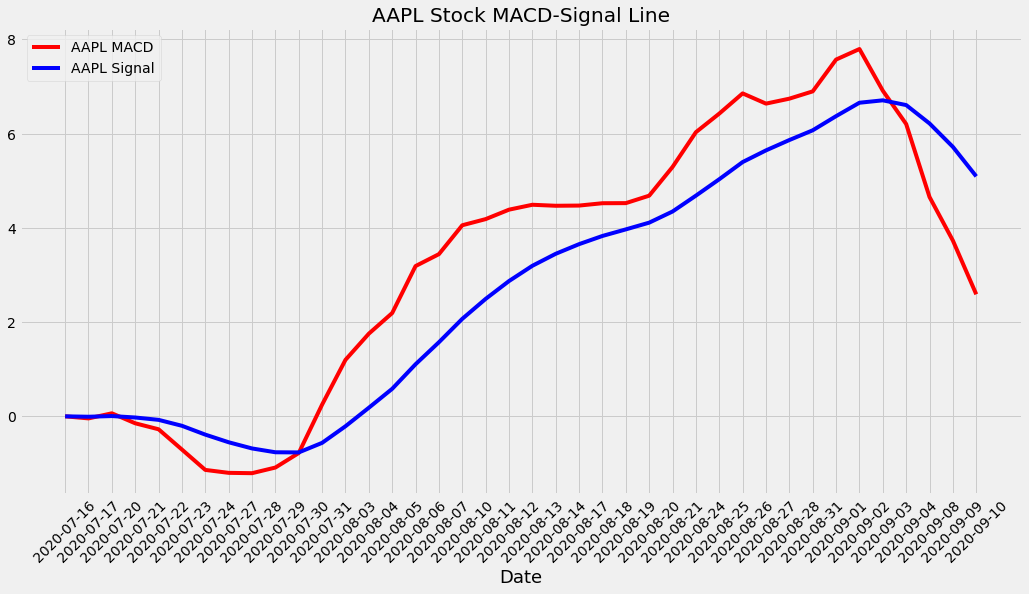

In [7]:
plt.figure(figsize = (16, 8))
plt.title(f"{symbol} Stock MACD-Signal Line")
plt.plot(df.index[:40], MACD[:40], label = f"{symbol} MACD", color = "red")
plt.plot(df.index[:40], signal[:40], label = f"{symbol} Signal", color = "blue")
plt.xlabel('Date', fontsize = 18)
plt.xticks(rotation = 45)
# plt.ylabel('Close Price(USD)', fontsize = 18)
plt.legend(loc = "upper left")
plt.show()

<h2 id="6">6. Signal When to Buy and Sell the Stock</h2>

In [8]:
def get_signals_to_buy_or_sell():
    """
        This function computes signals when to buy or sell.
    """
    signal_to_buy, signal_to_sell = [], []
    flag, NAN = -1, np.NaN
    for row in df.index:
        close, macd, sig = df.loc[row, 'close'], df.loc[row, 'MACD'], df.loc[row, 'signal']
        if macd > sig:
            signal_to_sell.append(NAN)
            if flag != 1:
                signal_to_buy.append(close)
                flag = 1
            else:
                signal_to_buy.append(NAN)
        elif macd < sig:
            signal_to_buy.append(NAN)
            if flag != 0:
                signal_to_sell.append(close)
                flag = 0
            else:
                signal_to_sell.append(NAN)
        else:
            signal_to_sell.append(NAN)
            signal_to_buy.append(NAN)
    return (signal_to_buy, signal_to_sell)

buy, sell = get_signals_to_buy_or_sell()
df['buy'] = buy
df['sell'] = sell

In [15]:
df

,open,high,low,close,volume,MACD,signal,buy,sell
date,,,,,,,,,
2020-07-16,99.3812,102.0720,97.4450,97.6085,114597937,0.000000,0.000000,NaN,NaN
2020-07-17,98.8391,101.7981,96.8300,98.4697,93540469,0.068700,0.013740,98.4697,NaN
2020-07-20,100.9377,102.2000,98.3758,102.0304,90959772,0.405786,0.092149,NaN,NaN
2020-07-21,103.0854,103.0854,97.0180,102.0000,107532853,0.662835,0.206286,NaN,NaN
2020-07-22,101.0621,101.4570,99.5699,100.9473,90923120,0.772697,0.319569,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-07-09,145.3800,151.9700,145.1889,151.9700,102335524,4.437020,3.052633,NaN,NaN
2021-07-12,148.0400,150.2000,145.0000,150.2000,79319219,4.676168,3.377340,NaN,NaN
2021-07-13,149.5100,153.7400,146.4900,152.6800,102970278,5.008079,3.703488,NaN,NaN


<h2 id="7">7. Visualize the Signals</h2>

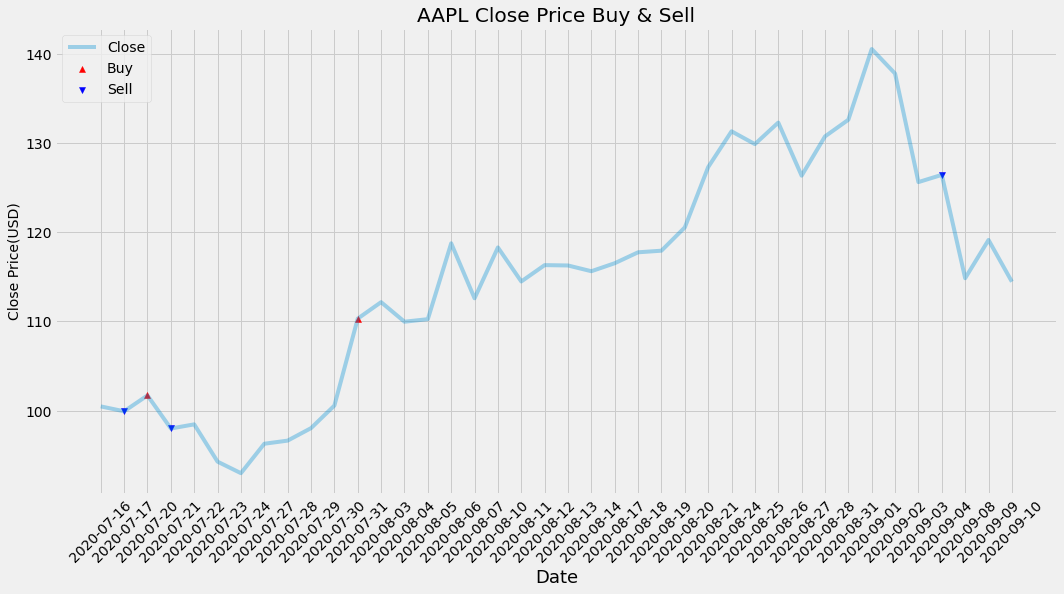

In [18]:
plt.figure(figsize = (16, 8))
plt.scatter(
    df.index[:40],
    df['buy'][:40],
    label = "Buy",
    marker = "^",
    color = "red",
    alpha = 1
)
plt.scatter(
    df.index[:40],
    df['sell'][:40],
    label = "Sell",
    marker = "v",
    color = "blue",
    alpha = 1
)
plt.plot(df['close'][:40], label = "Close", alpha = 0.35)
plt.title("AAPL Close Price Buy & Sell")
plt.xlabel('Date', fontsize = 18)
plt.xticks(rotation = 45)
plt.ylabel('Close Price(USD)', fontsize = 14)
plt.legend(loc = "upper left")
plt.show()